In [1]:
import torch
import lightning.pytorch as pl

from mymodels import Model_Wrapper, Preprocess
from myutils import View
from yolo_wrapper import YOLO_COCO_Wrapper
from coco_ds import CocoResults

import logging
logging.disable(logging.INFO)

In [2]:
# configs to speed up training
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
PATH_TO_COCO = '/f_storage/datasets/coco/2017'
NUM_IMG_EVAL = 10000
prep = Preprocess(PATH_TO_COCO, (640, 640), dataset_type='coco', shuffle=False, batch_size=64)
%matplotlib inline

In [4]:
prep.reset_trans()
coco = prep.get_loader()
model = YOLO_COCO_Wrapper(CocoResults(coco.dataset), 'yolov5n.pt')
model = Model_Wrapper(model, model_type='yolo')
# trainer = pl.Trainer(accelerator='auto', limit_test_batches=10)
trainer = pl.Trainer(accelerator='auto')

In [5]:
def compare_ds(model, dataloaders, labels, preview_idxs:list, view_only=False, show_bbox=True, figsize=(12,6), verbose=True, skip_results:list=[0]):
    results = {}
    samples = []
    #display first
    for ds in dataloaders:
        sample = torch.stack([ds.dataset[i][1] for i in preview_idxs])
        
        if show_bbox:
            samples.append(model.plot(sample))
        else:
            samples.append(sample)
        
    View.compare_color(samples, labels, figsize=figsize)

    
    if not view_only:
        for i in range(len(dataloaders)):
            if i in skip_results:
                continue
            
            result = trainer.test(model, dataloaders[i], verbose=verbose)
            results[labels[i]] = result
            
            
        return results
    else:
        return None

##### Test On Orignal Dataset

<Figure size 1000x600 with 0 Axes>

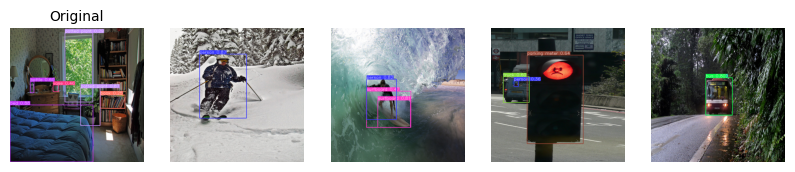

2023-09-28 11:37:09.207529: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    54.995426177978516     │
│      Pixel Val MEAN       │    112.38577270507812     │
│       Pixel Val STD       │     58.55387496948242     │
│        mAP 50:95 %        │     31.68928430960908     │
└───────────────────────────┴───────────────────────────┘

In [6]:
preview_idxs = [2, 53, 300, 607, 3584]
samples  = torch.stack([coco.dataset[i][1] for i in preview_idxs])
plots = model.plot(samples)
View.compare_color(plots, 'Original')
# View.histogram(samples)
orig_results = trainer.test(model, coco)

##### Test filters on Orignal Dataset

<Figure size 1200x600 with 0 Axes>

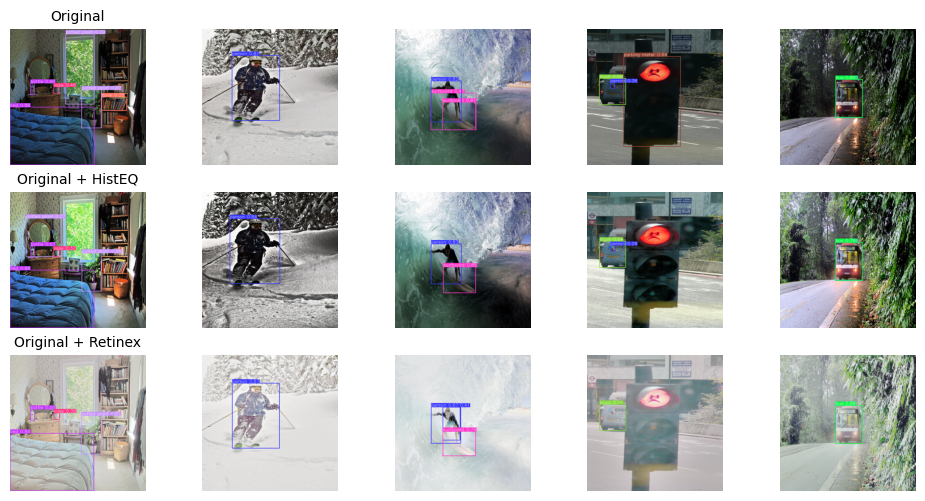

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     54.63329315185547     │
│      Pixel Val MEAN       │    109.80985260009766     │
│       Pixel Val STD       │     68.84072875976562     │
│        mAP 50:95 %        │    29.361666908590262     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    54.353187561035156     │
│      Pixel Val MEAN       │    189.79580688476562     │
│       Pixel Val STD       │     28.77806854248047     │
│        mAP 50:95 %        │    23.532744426516704     │
└───────────────────────────┴───────────────────────────┘

In [7]:
prep.reset_trans()
coco = prep.get_loader()
coco_histeq = prep.copy().hist_eq().get_loader()
coco_retinex = prep.copy().retinex('SSR', 100).get_loader()
coco_results = compare_ds(model, 
                                 [coco, coco_histeq, coco_retinex],
                                 ['Original', 'Original + HistEQ', 'Original + Retinex'], 
                                 preview_idxs,
                                 view_only=False)

##### Test on Dark Images

<Figure size 1200x600 with 0 Axes>

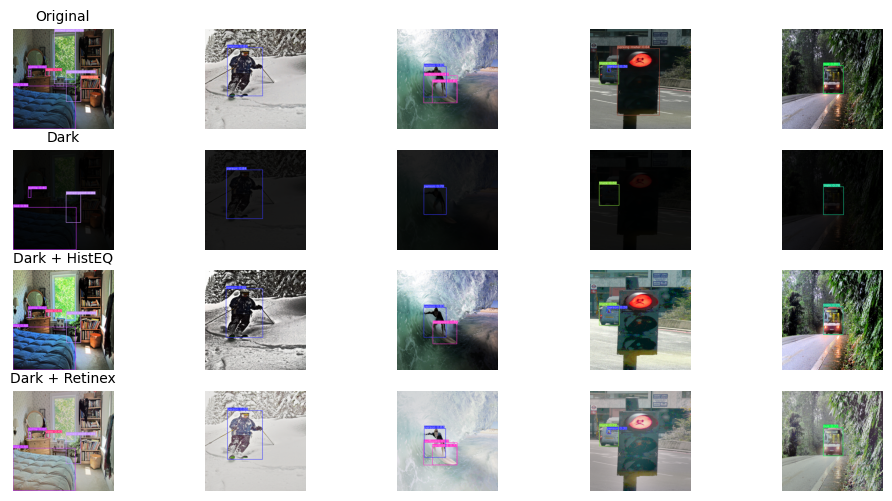

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     54.23139953613281     │
│      Pixel Val MEAN       │    14.048221588134766     │
│       Pixel Val STD       │     7.319234371185303     │
│        mAP 50:95 %        │    19.795612429217186     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    54.587799072265625     │
│      Pixel Val MEAN       │    113.30384063720703     │
│       Pixel Val STD       │     70.78779602050781     │
│        mAP 50:95 %        │    28.805827184990463     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     54.50286102294922     │
│      Pixel Val MEAN       │     167.663818359375      │
│       Pixel Val STD       │     35.70078659057617     │
│        mAP 50:95 %        │    26.156535486257035     │
└───────────────────────────┴───────────────────────────┘

In [8]:
prep.reset_trans()
coco_dark = prep.luminance(1/8).get_loader()
coco_dark_histeq = prep.copy().hist_eq().get_loader()
coco_dark_retinex = prep.copy().retinex('SSR', 100).get_loader()
coco_dark_results = compare_ds(model, 
                                 [prep.basic_loader(), coco_dark, coco_dark_histeq, coco_dark_retinex],
                                 ['Original', 'Dark', 'Dark + HistEQ', 'Dark + Retinex'], 
                                 preview_idxs,
                                 view_only=False)

##### Test on Over Exposed Images

<Figure size 1200x600 with 0 Axes>

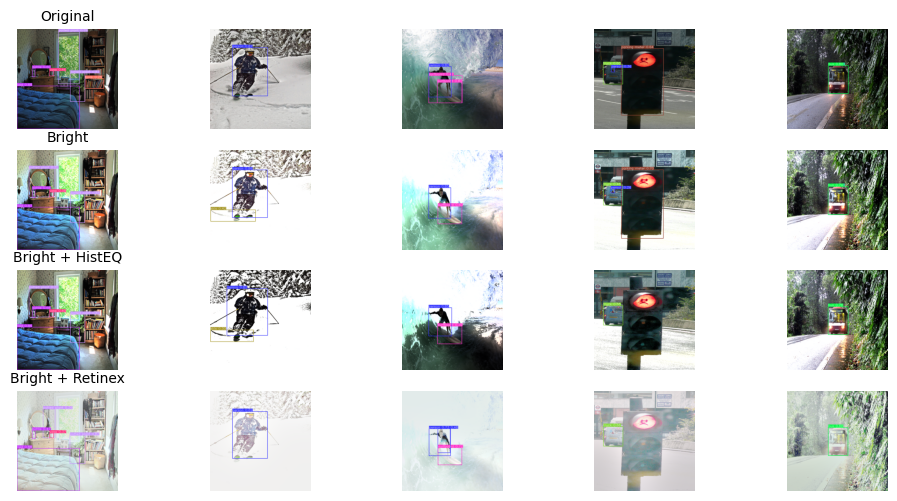

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    53.454105377197266     │
│      Pixel Val MEAN       │     177.4310760498047     │
│       Pixel Val STD       │     69.90850830078125     │
│        mAP 50:95 %        │    23.978518569189507     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     52.26437759399414     │
│      Pixel Val MEAN       │    152.60775756835938     │
│       Pixel Val STD       │     90.97545623779297     │
│        mAP 50:95 %        │     19.53440723634895     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     52.46411895751953     │
│      Pixel Val MEAN       │     209.1963653564453     │
│       Pixel Val STD       │    26.507644653320312     │
│        mAP 50:95 %        │    16.958961700222797     │
└───────────────────────────┴───────────────────────────┘

In [9]:
prep.reset_trans()
coco_bright = prep.luminance(2).get_loader()
coco_bright_histeq = prep.copy().hist_eq().get_loader()
coco_bright_retinex = prep.copy().retinex('SSR', 100).get_loader()
coco_bright_results = compare_ds(model, 
                                 [prep.basic_loader(), coco_bright, coco_bright_histeq, coco_bright_retinex],
                                 ['Original', 'Bright', 'Bright + HistEQ', 'Bright + Retinex'], 
                                 preview_idxs)

##### Test on hazy images

<Figure size 1200x600 with 0 Axes>

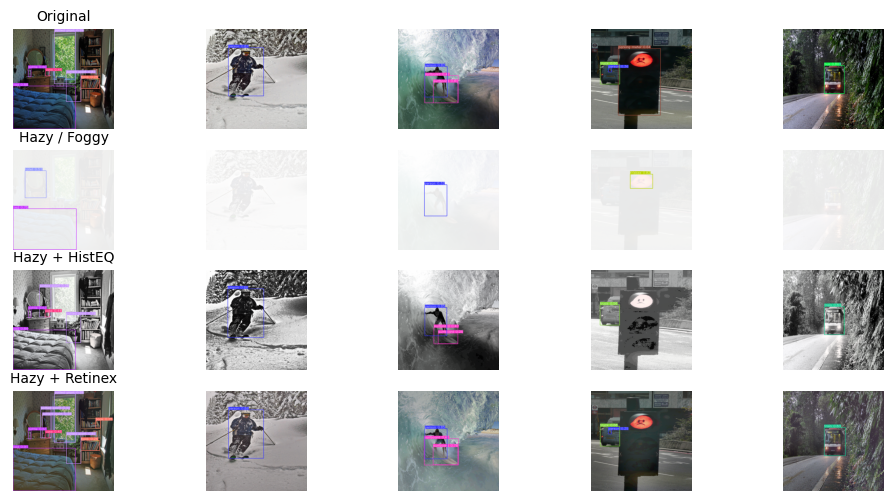

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     48.91856002807617     │
│      Pixel Val MEAN       │     242.1079559326172     │
│       Pixel Val STD       │     5.324141979217529     │
│        mAP 50:95 %        │    5.1417261383228245     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     53.50002670288086     │
│      Pixel Val MEAN       │      135.72314453125      │
│       Pixel Val STD       │     74.34676361083984     │
│        mAP 50:95 %        │     22.02619098611941     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    54.949485778808594     │
│      Pixel Val MEAN       │    117.34870147705078     │
│       Pixel Val STD       │     36.63230514526367     │
│        mAP 50:95 %        │    29.431228520059456     │
└───────────────────────────┴───────────────────────────┘

In [10]:
prep.reset_trans()
coco_mod = prep.fog(10).get_loader()
coco_mod_histeq = prep.copy().hist_eq().get_loader()
coco_mod_retinex = prep.copy().retinex('SSR', 100).get_loader()
coco_mod_results = compare_ds(model, 
                                 [prep.basic_loader(), coco_mod, coco_mod_histeq, coco_mod_retinex],
                                 ['Original', 'Hazy / Foggy', 'Hazy + HistEQ', 'Hazy + Retinex'], 
                                 preview_idxs,
                                 view_only=False)

##### Test on Dark Rainy Images

<Figure size 1200x600 with 0 Axes>

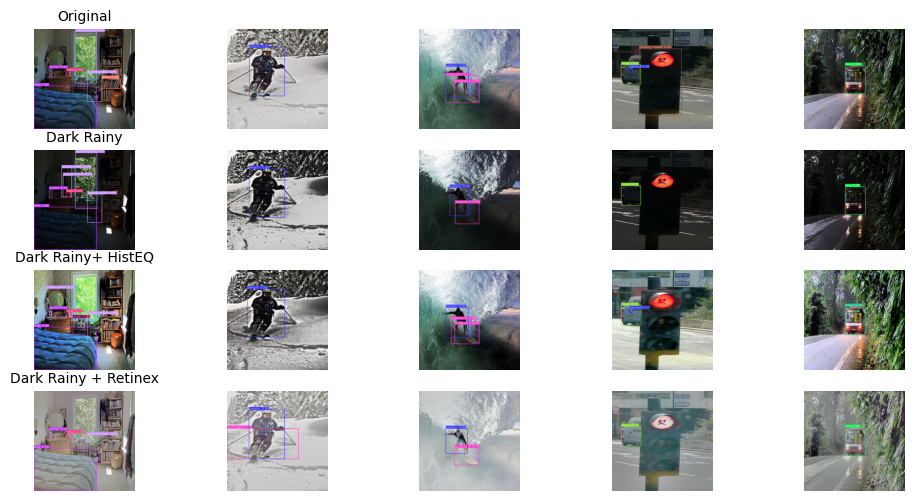

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     53.93056869506836     │
│      Pixel Val MEAN       │     69.02387237548828     │
│       Pixel Val STD       │     65.90249633789062     │
│        mAP 50:95 %        │    24.736954895483997     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     54.57737350463867     │
│      Pixel Val MEAN       │    109.60608673095703     │
│       Pixel Val STD       │     68.97256469726562     │
│        mAP 50:95 %        │     29.39304007935238     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    53.721229553222656     │
│      Pixel Val MEAN       │    155.97674560546875     │
│       Pixel Val STD       │     34.45027542114258     │
│        mAP 50:95 %        │    22.581269456773136     │
└───────────────────────────┴───────────────────────────┘

In [11]:
prep.reset_trans()
coco_mod = prep.rain(2, 75).get_loader()
coco_mod_histeq = prep.copy().hist_eq().get_loader()
coco_mod_retinex = prep.copy().retinex('SSR', 100).get_loader()
coco_mod_results = compare_ds(model, 
                                 [prep.basic_loader(), coco_mod, coco_mod_histeq, coco_mod_retinex],
                                 ['Original', 'Dark Rainy', 'Dark Rainy+ HistEQ', 'Dark Rainy + Retinex'], 
                                 preview_idxs,
                                 view_only=False)

##### Test Histogram Eq on Low Contrast Images

In [12]:
# prep.reset_trans()
# coco_low_cont = prep.brightness_contrast(0,5).get_loader()
# coco_low_cont_histeq = prep.copy().hist_eq().get_loader()
# coco_low_cont_retinex = prep.copy().retinex('SSR', 100).get_loader()
# coco_low_cont_results = compare_ds(model, 
#                                  [prep.basic_loader(), coco_low_cont, coco_low_cont_histeq, coco_low_cont_retinex],
#                                  ['Original', 'Low Contrast', 'Low Contrast + HistEQ', 'Low Contrast + Retinex'], 
#                                  preview_idxs)

##### Test Remapping Distribution to be low contrast

In [13]:
# prep.reset_trans()
# coco_mod = prep.dist_remap(20/255,20/255).get_loader()
# coco_mod_histeq = prep.copy().hist_eq().get_loader()
# coco_mod_retinex = prep.copy().retinex('SSR', 100).get_loader()
# coco_mod_results = compare_ds(model, 
#                                  [prep.basic_loader(), coco_mod, coco_mod_histeq, coco_mod_retinex],
#                                  ['Original', 'Low Contrast', 'Low Contrast + HistEQ', 'Low Contrast + Retinex'], 
#                                  preview_idxs,
#                                  view_only=False)

: 